### 0.导入函数库

In [1]:
%matplotlib inline
from scipy import fftpack
from obspy.signal.invsim import cosine_taper 
from obspy.core import read
from matplotlib import rcParams
import numpy as np
import matplotlib.pylab as plt
from utilities.plot_tools import plot_fft
import matplotlib
import warnings
warnings.filterwarnings("ignore")
matplotlib.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': False,
                            # Use the Computer modern font
                            'font.family': 'serif',
                            'font.serif': 'cmr10',
                            'mathtext.fontset': 'cm',
                            # Use ASCII minus
                            'axes.unicode_minus': False,
                            })
plt.rcParams['figure.figsize'] = 15, 3


傅里叶变换是基于傅里叶级数的。通过傅里叶级数，我们可以用一系列由一些系数加权的基函数的求和来近似一个函数 f(x)。基函数需要是正交的。正弦和余弦函数似乎是一个很好的选择，因为任何信号都可以被滤波成几个正弦波。在周期范围 [−T/2;T/2] 内，傅里叶级数定义为：
  
$$ f(t)\approx{g_n(t)}=\frac{1}{2}a_0+\sum^{N}_{k=1}\left[a_k{cos\left(\frac{2\pi{kt}}{T}\right)}+{b_k}sin\left(\frac{2\pi{kt}}{T}\right)\right] $$
 
$$ a_k=\frac{2}{T}\int_{-\frac{T}{2}}^\frac{T}{2}{f(t)}{cos\left(\frac{2\pi{kt}}{T}\right)}dt $$
 
$$ b_k=\frac{2}{T}\int_{-\frac{T}{2}}^\frac{T}{2}{f(t)}{sin\left(\frac{2\pi{kt}}{T}\right)}dt $$
 
对于非周期函数，周期性的区间趋向于无穷大。因此傅里叶级数的无穷和变成了积分，我们最终得到了傅里叶变换的积分形式：

$$ f(t)={\int^{\infty}_{−\infty}}F(\omega)e^{i{\omega}t}dt $$

在地震学中，我们没有连续的时间信号，而是离散的。因此，我们使用离散形式的傅里叶变换：

$$ f_k=\sum^{N-1}_{j=1}F_j{e^{2{\pi}ikj/N}} $$


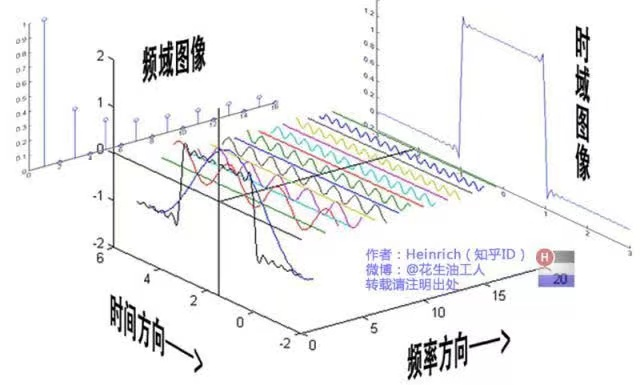

### 1.傅里叶变换

创建一个频率为4 Hz、采样率为100Hz的正弦波，通过FFT将其转换到频域。
```
1) 由于信号是由单一频率产生的，应该在该频率的图中得到一个脉冲。但是得到了一个三角形，表明部分能量/幅度分布在4Hz的中心频率附近。这就是所谓的频谱泄漏，即中心频率的“模糊”。原因在于傅里叶变换，它假设信号是无限的。信号的有限长度限制了频率间距：Δf=1/T。
2) 时域信号越长，频率峰值越明显。时域中长信号意味着频域中的良好分辨率，反之亦然。这也被称为不确定性原理。
3) 通过在时域中对信号进行零填充（即在信号的开头和结尾添加幅度为零的额外样本）来人为地增加信号的长度。因此，我们不是添加信息（其他频率），而只是增加信号的长度，从而提高频率分辨率。
```

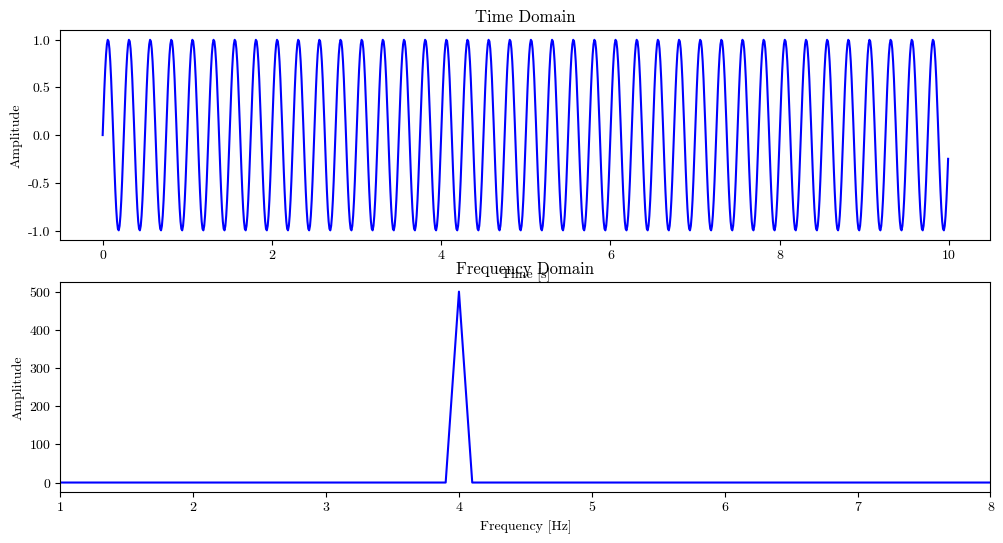

In [2]:
# leng = 50.0
leng = 10.0                                 # 信号长度（以秒为单位，初始值：2秒
dt = 1./100.                                # 采样间隔
ny = 1/dt/2.                                # 奈奎斯特频率
t = np.arange(0, leng, dt)                  # 时间轴
gen_single  = np.sin(2 * 4 * np.pi * t)     # 生成一个正弦波作为信号

Fsin = np.fft.rfft(gen_single)              # 信号通过FFT转换到频域
f = np.linspace(0, ny, len(Fsin))           # 频率轴

# 绘图
plt.rcParams['figure.figsize'] = 12, 6
plt.subplot(211)
plt.plot(t, gen_single, 'b')
plt.title('Time Domain')
plt.ylim(-1.1,1.1)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(212)
plt.plot(f, abs(Fsin), 'b')
plt.xlim(1,8)
plt.title('Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.show()

### 2.傅里叶级数和系数

(1)计算给定函数的傅里叶级数的系数

In [3]:

def fourier_series_coeff(f, T, N):
    """
    计算周期函数的前2*N+1个傅里叶级数系数。
    
    Parameters
    f: 周期函数, 类似于f(t)的可调用对象
    T: 函数f的周期, 使得f(0)==f(T)
    N: 函数将返回前N + 1个傅里叶系数。

    Returns
    a0: 浮点数
    a, b: numpy浮点数组, 分别描述余弦和正弦系数。
    """
    # 在周期T内对f进行采样的点数。
    # 根据奈奎斯特定理，信号的采样频率，要等于大于想在信号中捕获的最大频率的2倍。 
    f_sample = 2 * N
    
    t, dt = np.linspace(0, T, f_sample + 2, endpoint=False, retstep=True)
    y = np.fft.rfft(f) / t.size
    y *= 2
    return y[0].real, y[1:-1].real[0:N], -y[1:-1].imag[0:N]

# 根据给定的系数和加权因子创建一个函数
def series_real_coeff(a0, a, b, t, T):
    """
    计算傅里叶级数
    """
    tmp = np.ones_like(t) * a0 / 2.
    for k, (ak, bk) in enumerate(zip(a, b)):
        tmp += ak * np.cos(2 * np.pi * (k + 1) * t / T) + bk * np.sin(
            2 * np.pi * (k + 1) * t / T)
    return tmp

(2)创建周期性的离散有限信号

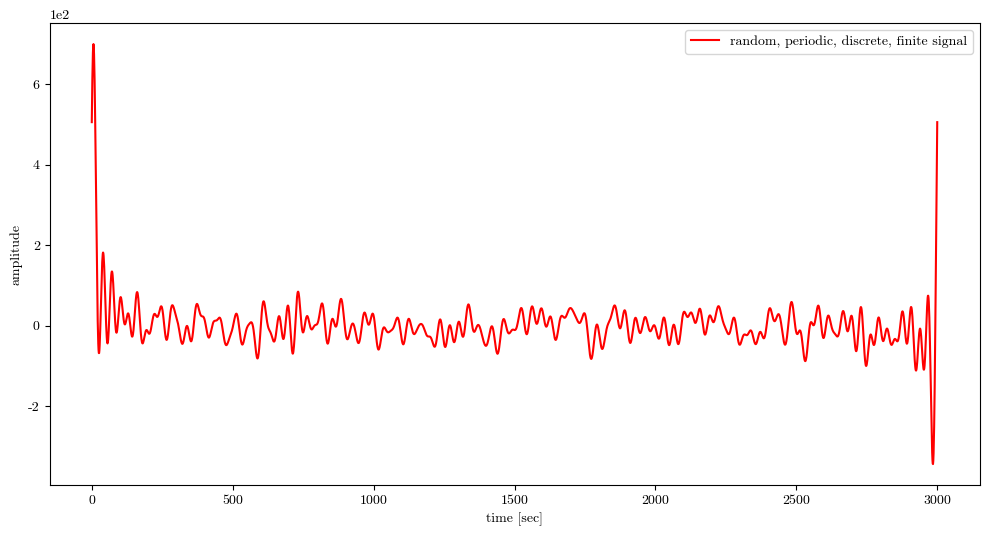

In [4]:
samp = 3000      # 样本数
dt = 1           # 采样率
T = 1.0 / dt     # 周期
length = samp * dt
N = 100          # 系数数量（初始值：100）

# 系数的加权因子（随机选择）
a0 = np.random.rand(1)
a = np.random.randint(1, high=11, size=N)
b = np.random.randint(1, high=11, size=N)

t = np.linspace(0, length, samp)             # 时间轴
sig = series_real_coeff(a0, a, b, t, T)

# 绘图
plt.plot(t, sig, 'r', label='random, periodic, discrete, finite signal')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
plt.xlabel('time [sec]')
plt.ylabel('amplitude')
plt.legend()
plt.show()

(3)计算函数的前n个系数

coefficient a0 =  82
array coefficients ak = [ 864  730 1001 1414  321  735 1411 1139  727  466]
array coefficients bk = [ 137 1092  274 1363  686 1092  269  681  413 1232]


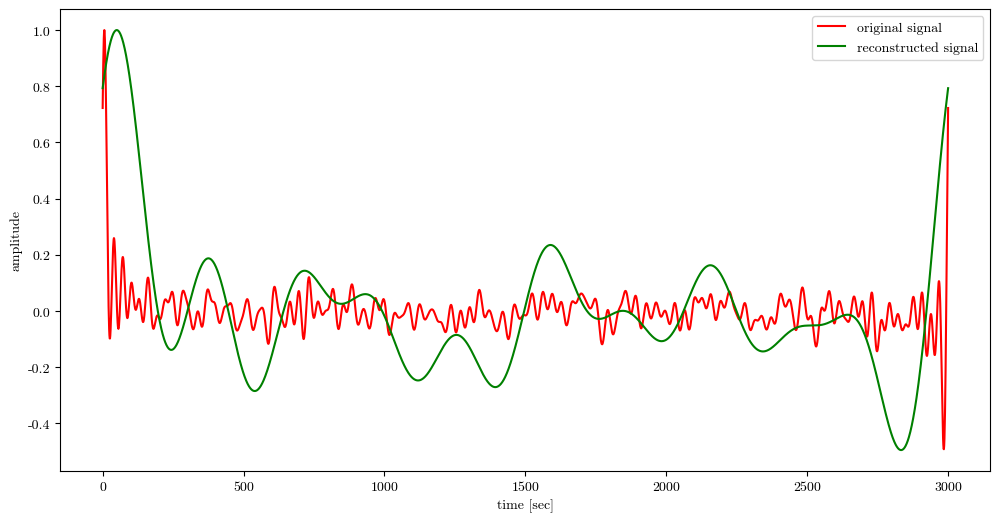

In [5]:
T = 1        # 周期
n = 10        # 要重构的系数数量
a0, a, b = fourier_series_coeff(sig, T, n)
a_ = a.astype(int)
b_ = b.astype(int)
print('coefficient a0 = ', int(a0))
print('array coefficients ak =', a_)
print('array coefficients bk =', b_)

# 重构函数
g = series_real_coeff(a0, a, b, t, dt)

# 绘图
#plt.plot(t, sig, 'b', label='original signal')           # 没有归一化
#plt.plot(t, g, 'y', label='reconstructed signal')
plt.plot(t, sig/max(sig), 'r', label='original signal')   # 归一化 
plt.plot(t, g/max(g), 'g', label='reconstructed signal')

plt.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
plt.xlabel('time [sec]')
plt.ylabel('amplitude')
plt.legend()
plt.show()

(4)傅里叶变换信号

Text(0, 0.5, 'Amplitude')

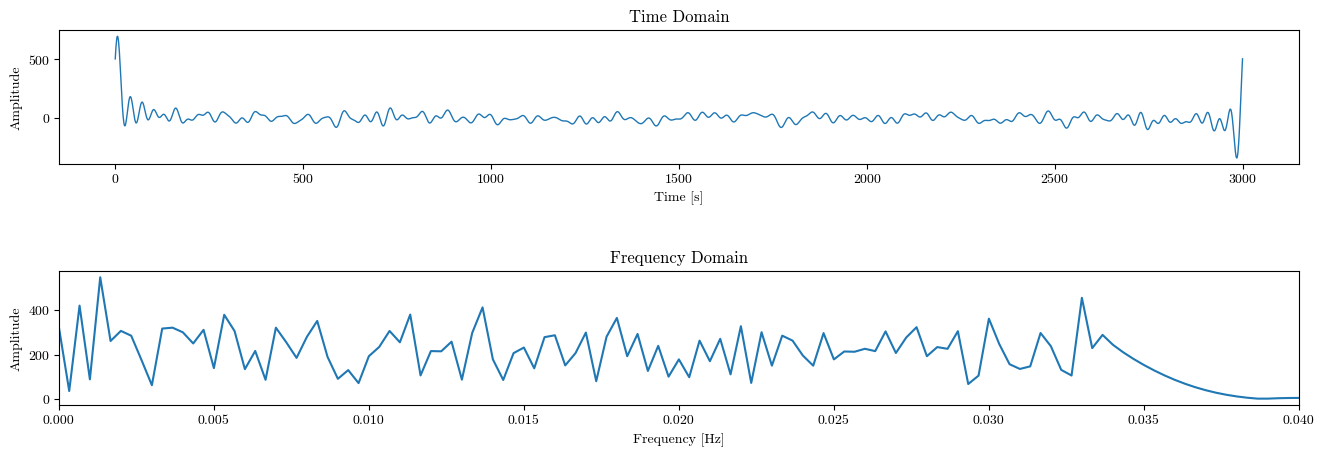

In [6]:
taper_percentage = 0.1      # 应用于信号的锥度百分比（初始值：0.1）
npts = 50                  
taper = cosine_taper(samp,taper_percentage)

sig_ = sig * taper
Fsig = np.fft.rfft(sig_, n=samp)
xf = np.linspace(0.0, 1.0/(2.0*T), int((samp/2)+1))

# 绘图
rcParams["figure.subplot.hspace"] = (0.8)
rcParams["figure.figsize"] = (16, 8)
plt.subplot(311)
plt.title('Time Domain')
plt.plot(t, sig, linewidth=1)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(312)
plt.title('Frequency Domain')
plt.plot(xf, 2.0/npts * np.abs(Fsig))
plt.xlim(0, 0.04)                                
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

### 3.地震信号的傅里叶变换

(1)原始波形变换

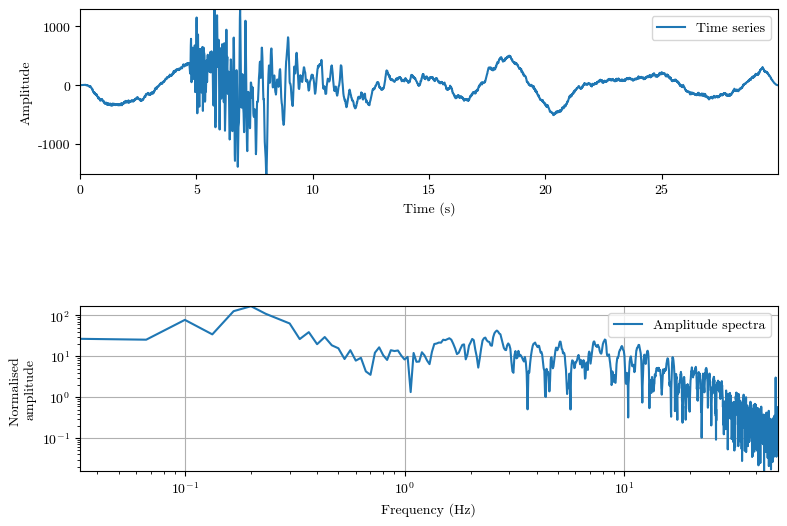

In [7]:
st = read("../data/test_trace.mseed")
tr = st[0]

x = np.arange(0, tr.stats.npts * tr.stats.delta, tr.stats.delta)
y = tr.data

rcParams["figure.figsize"] = (9, 6)
fig = plot_fft(x, y,reconstruct=False)

(2)降采样后波形变换

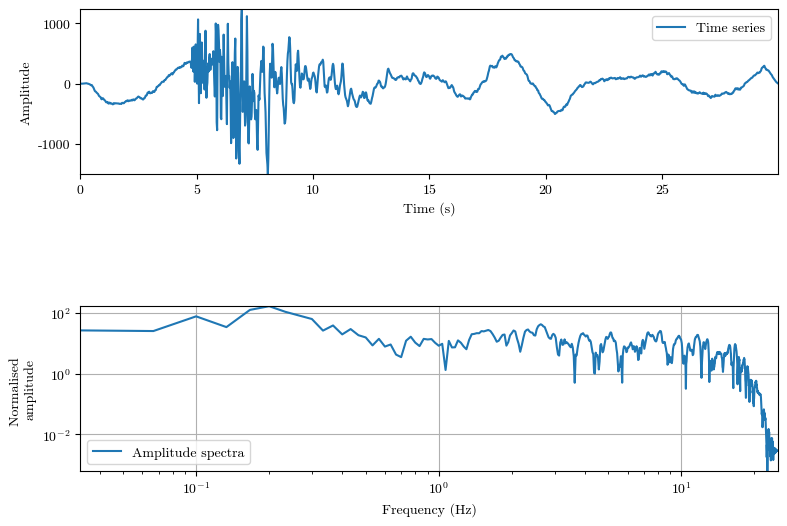

In [8]:
tr_decimated = tr.copy().decimate(2)  # 降采样

x = np.arange(0, tr_decimated.stats.npts * tr_decimated.stats.delta, tr_decimated.stats.delta)
y = tr_decimated.data

fig = plot_fft(x, y, reconstruct=False)

### 4.吉布斯现象(Gibb's phenomenon)
指在使用离散傅里叶变换（Discrete Fourier Transform，DFT）时，由于只使用有限数量的项来描述频率内容，因此容易出现的现象。Gibb's现象在时间序列中存在不连续性（或者在频谱中存在不连续性）时会发生。不连续性（例如阶跃）无法用有限数量的正弦波准确表示：时间域中的阶跃包含无限频率。由于正弦波的过冲引起的振荡现象被称为Gibb's现象。
```
在下面人为地在先前的时间序列中引入了一个阶跃。请注意，这个阶跃的偏移也在时间序列的起始和结束处引入了一个阶跃，因为傅里叶变换假设信号是周期性的。我们可以看到频谱在频率上“振铃”，不断地回到几乎平坦的频谱，直到奈奎斯特频率。
```

(1)阶跃信号傅里叶变换

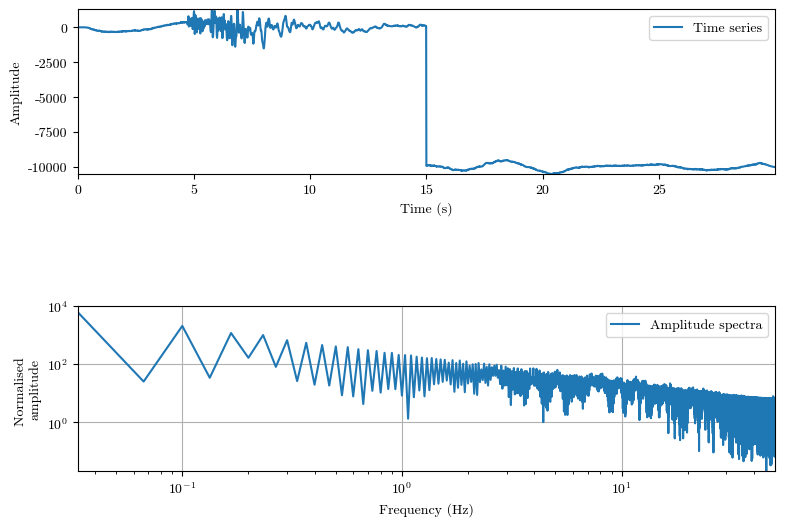

In [9]:
st = read("../data/test_trace.mseed")
tr = st[0]

step_position = int(tr.stats.npts / 2)
x = np.arange(0, tr.stats.npts * tr.stats.delta, tr.stats.delta)
tr_stepped = tr.copy()
tr_stepped.data[step_position:] -= 1e4
y = tr_stepped.data

fig = plot_fft(x, y, reconstruct=False)

(2)阶跃信号反傅里叶变换（振铃现象）

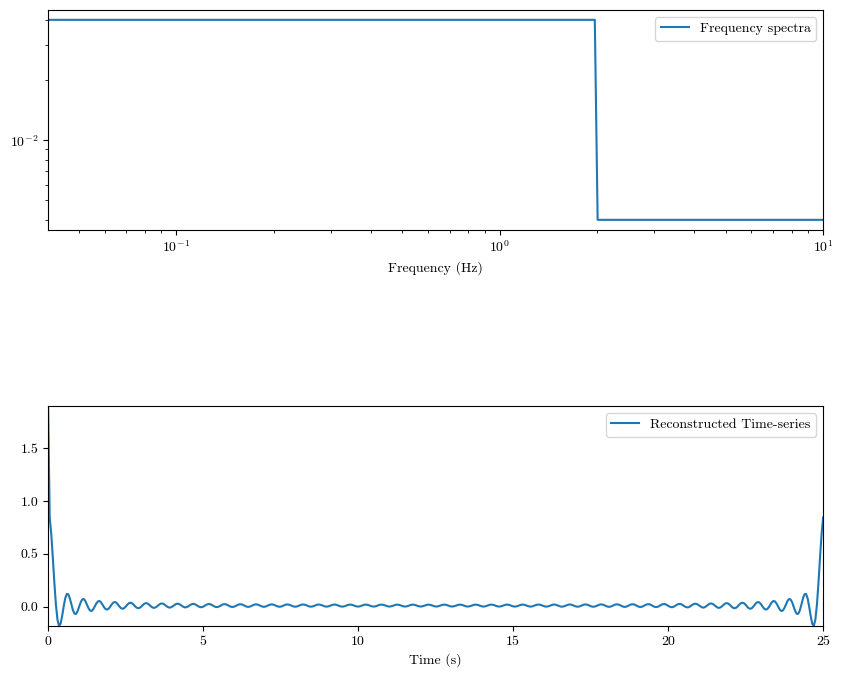

In [10]:
N = 500
dt = 0.05
step_position = 2  # 阶跃的位置（频率）为 Hz
sample_frequency = 1.0 / dt
nyquist = sample_frequency / 2.0

# 检查阶跃是否在幅度谱的可分辨部分内
if step_position >= nyquist:
    raise NotImplementedError(
        "Step should be below nyquist: {0}".format(nyquist))

# 首先制作一个振幅为10的平坦频谱
frequency_amplitudes = np.ones(N) * 10
# 计算频率采样间隔
frequency_interval = nyquist / int(N / 2)

# 在幅度谱中插入一个阶跃
step_location = int(step_position / frequency_interval)
frequency_amplitudes[step_location:] = np.ones_like(
    frequency_amplitudes[step_location:])
# 生成绘图的频率采样点
frequency_samples = np.linspace(0.0, 1.0 / (2. * dt), int(N / 2))

# 进行逆傅里叶变换
yr = fftpack.ifft(frequency_amplitudes)
x = np.linspace(0.0, N * dt, N)

# 绘图
fig, ax = plt.subplots(nrows=2, figsize=(10, 8))
ax[0].loglog(frequency_samples, 2./N * np.abs(frequency_amplitudes[:N//2]), 
             label="Frequency spectra")
ax[0].set_xlabel("Frequency (Hz)")
ax[0].autoscale(enable=True, axis='x', tight=True)
ax[0].legend()

# Plot the resulting time-series from the inverse FFT
ax[1].plot(x, np.real(yr), label="Reconstructed Time-series")
ax[1].set_xlabel("Time (s)")
ax[1].autoscale(enable=True, axis='both', tight=True)
_ = ax[1].legend()

### 5.锥形计算

Before Taper
amplitude of first sample point:   1.7
amplitude of last sample point:  -0.0
After Taper
amplitude of first sample point:   0.0
amplitude of last sample point:  -0.0


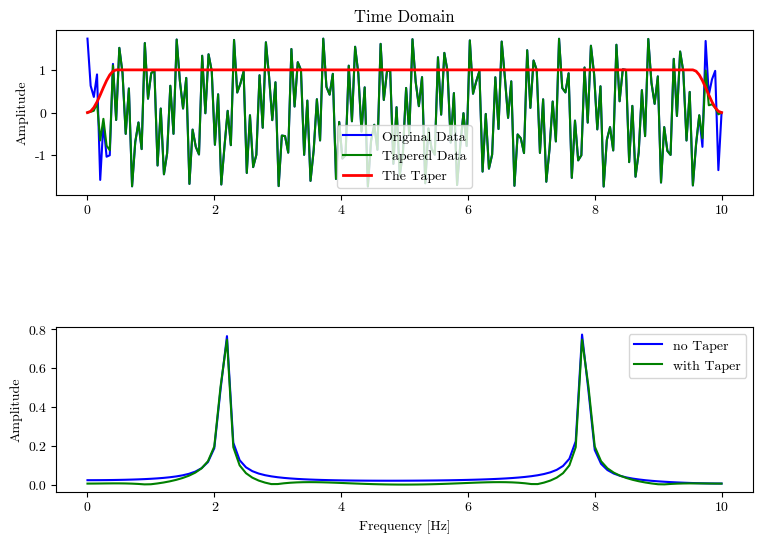

In [11]:
samp = 200                                # 采样点数量（初始值：200）
delta = 0.05                              # 采样间隔（初始值：0.05）
freq1 = 2.15                              # 产生信号的发生器频率（初始值：2.15）
freq2 = 7.8                               # 产生信号的发生器频率（初始值：7.8）
temp = np.linspace(0.0, samp*delta, samp) # 时间轴（单位：秒）

# 设置初始信号
# 生成频率为freq1赫兹的正弦波信号
# dat = np.sin(freq1 * 2.0 * np.pi * temp)
# 为正弦波的零点添加一个偏移量
dat = np.sin(freq1 * 2.0 * np.pi * temp + np.pi/3)
## 将频率为freq2赫兹的另一个正弦波添加到信号中
dat = dat + np.sin(freq2 * 2.0 * np.pi * temp + np.pi/3)
#noise_amplitude = 0.7
## 为信号添加噪声
#dat = dat + np.random.randn(len(dat)) * noise_amplitude 
# 确定数据的最大振幅（用于绘图）
maximum = max(dat)

print('Before Taper')
print('amplitude of first sample point:%6.1f' %dat[0])
print('amplitude of last sample point:%6.1f' %(dat[len(dat)-1]))

# 定义平滑窗
# 应用的锥度百分比[0-1]（初始值：0.1）
taper_percentage = 0.1
# 定义锥度窗口。
taper = cosine_taper(samp,taper_percentage)
# 对信号进行锥度处理。
dat_taper = dat * taper

print('After Taper')
print('amplitude of first sample point:%6.1f' %dat_taper[0])
print('amplitude of last sample point:%6.1f' %(dat_taper[len(dat_taper)-1]))

# 将FFT数据转换为频域数据
Fdat = np.fft.rfft(dat, n=samp)
Fdat_taper = np.fft.rfft(dat_taper, n=samp)
# 用于绘图的频域x轴
xf = np.linspace(0.0, 1.0/(2.0*delta), int((samp/2)+1))

# 绘图
plt.subplot(211)
plt.title('Time Domain')
plt.plot(temp, dat, label="Original Data", color='b', linewidth=1.5)
plt.plot(temp, dat_taper, label="Tapered Data", color='g',linewidth=1.5)
plt.plot(temp, taper, label="The Taper", color='r', linewidth=2)
plt.legend(loc='lower center')
plt.ylabel('Amplitude')
plt.ylim(-(maximum+0.2),maximum+0.2)

plt.subplot(212)
plt.plot(xf, 2.0/samp * np.abs(Fdat), color='b',label="no Taper",linewidth=1.5)
plt.plot(xf, 2.0/samp * np.abs(Fdat_taper), label="with Taper", color='g',linewidth=1.5)
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.show()

### 6.远震、近震谱比较
体波的衰减速率为 $ ar^{-2} $, 面波的衰减速率为 $ ar^{-1} $，a为振幅，r为距离。<br>
这意味着在靠近地震源的地方记录数据时，能看到比在远震距离下记录的数据中有更高的频率。

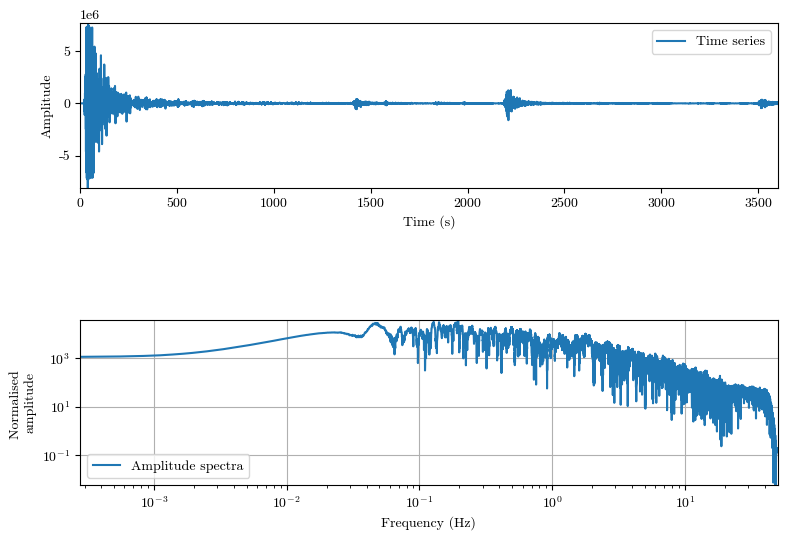

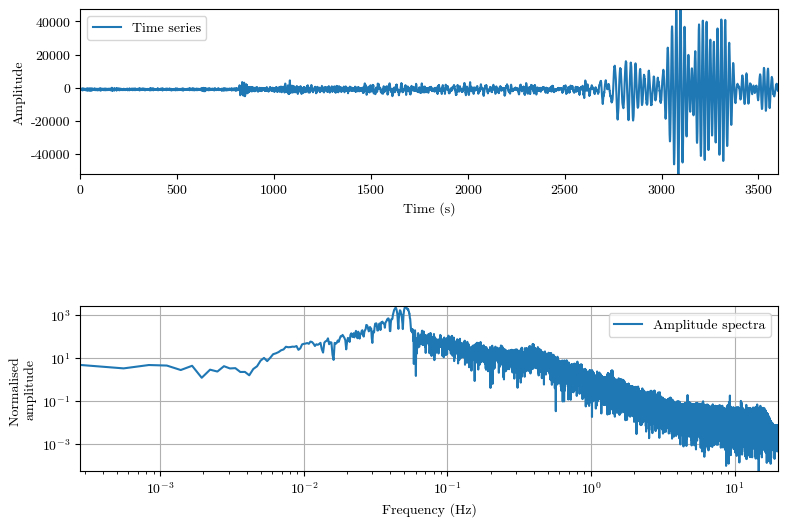

In [12]:
from utilities.plot_tools import plot_fft

local_st = read("../data/nz_localseismic.mseed")
local_tr = local_st.select(channel="HHZ")[0]
x = np.arange(0, local_tr.stats.npts * local_tr.stats.delta, local_tr.stats.delta)
y = local_tr.data
fig = plot_fft(x, y, reconstruct=False)

tele_st = read("../data/nz_teleseismic.mseed")
tele_tr = tele_st.select(channel="BHZ")[0]
x = np.arange(0, tele_tr.stats.npts * tele_tr.stats.delta, tele_tr.stats.delta)
y = tele_tr.data
fig = plot_fft(x, y, reconstruct=False)